***
# **FloodProofs Labs - HMC Training - Model Runner - Realtime Viewer** 

<img style="float: left; padding-right: 80px; padding-left: 5px;" src="img/logo_hmc.png" width="200px" align=”left” >

In the laboratory of **Continuum Model Runner - Realtime Viewer** we will perform the following points:
   * Configure the libraries and the dependecies of the laboratory;
   * Read the configuration file of the laboratory;
   * Set the funcions for plotting results in realtime mode;
   * Import **shared variables** file to use the information saved in the **Model Runner - Realtime Execution** Jupyter Notebook;
   * Configure the static datasets (**shapefile file section**);
   * Configure the dynamic datasets (**hmc.hydrographs.txt**);
   * Plot the model results in realtime mode to check and analyze the status of the run. 

### **Import libraries and dependencies**

In [51]:
%matplotlib inline
#%matplotlib widget

In [54]:
# Add hmc library to the paths environment
import sys
import os

# Info
print(' ==> Add HMC library in the environment ... ') 

folder_home_env = os.path.expanduser('~')
folder_library_hmc = "/fp_labs_hmc/library/jupyter_hmc/"

folder_library_hmc = folder_home_env + folder_library_hmc
sys.path.append(folder_library_hmc)

# Info
print(' ===> Added in: ' + folder_library_hmc)
print(' ==> Add HMC library in the environment ... DONE')  

 ==> Add HMC library in the environment ... 
 ===> Added in: /home/fabio/fp_labs_hmc/library/jupyter_hmc/
 ==> Add HMC library in the environment ... DONE


In [55]:
# Libraries
print(' ==> Load generic and package libraries ... ')

import pickle
import os
import time
import numpy as np

# Add hmc library to the paths environment
from library.jupyter_generic.lib_jupyter_utils_io import update_json_file

from library.jupyter_generic.lib_jupyter_utils_system import make_folder

from library.jupyter_generic.lib_jupyter_data_io_json import read_file_settings
from library.jupyter_generic.lib_jupyter_data_geo_shapefile import read_data_section
from library.jupyter_generic.lib_jupyter_data_io_ascii import read_file_ascii_hydrograph
from library.jupyter_generic.lib_jupyter_plot_realtime import adjust_ts_realtime, get_info_realtime

from IPython.display import clear_output

import matplotlib.pylab as plt

def write_pickle(file_name, file_data):
    if os.path.exists(file_name):
        os.remove(file_name)
    with open(file_name,'wb') as file_handle:
        pickle.dump(file_data, file_handle) 

def read_pickle(file_name):
    if not os.path.exists(file_name):
        raise IOError('File ' + file_name + ' not found!')
    file_handle = open(file_name,'rb')  
    file_data = pickle.load(file_handle)  
    return file_data

# File name for sharing variable(s)
file_name_shared_vars = "shared_variables.workspace"
# Section in each graph
section_n_graph = 10

# Info
print(' ==> Load generic and package libraries ... DONE')

 ==> Load generic and package libraries ... 
 ==> Load generic and package libraries ... DONE


### **Set function(s) for realtime plots**

In [78]:
# Method to plot time-series live
def plot_ts_realtime(file_name, file_time_stamp, file_dframe,
                     fig_y_label='Discharge [m^3/s]', fig_title_generic='HMC Time-Series',
                     fig_y_min=0, fig_y_max=100, fig_dpi=150, fig_show=True, fig_jupyter=True,
                     fig_update=True):
    
    select_tag = list(file_dframe.columns)
    select_n = select_tag.__len__()
    
    file_time_string = file_time_stamp.strftime('%Y-%d-%m %H:00')

    fig_title_info = ' === Time: ' + file_time_string
    fig_title = fig_title_generic + fig_title_info
    
    clear_output(wait=True)
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))

    p = ax.plot(file_dframe.index, file_dframe[select_tag].values, linestyle='-', lw=2)

    ax.set_xlim(file_dframe.index[0], file_dframe.index[-1])
    ax.set_ylim(fig_y_min, fig_y_max)

    ax.set_title(fig_title)
    ax.set_ylabel(fig_y_label)
    ax.grid(b=True)

    p_handle_list = []
    for i in range(0, select_n):
        p_handle_list.append(p[i])
    legend = ax.legend(p_handle_list, select_tag, frameon=False, loc=2)
    ax.add_artist(legend)

    plt.show()
    
    if fig_update:
        if os.path.exists(file_name):
            os.remove(file_name)
    
    fig.savefig(file_name, dpi=fig_dpi)

    if not fig_show:
        plt.close()

### **Configure the Continuum laboratory**
- Load the shared variables

In [57]:
# Info
print(' ==> Load shared variables ... ')

# Read pickle file of shared variable(s)
variables_shared = read_pickle(file_name_shared_vars)

# Info
print(' ==> Load shared variables ... DONE')

 ==> Load shared variables ... 
 ==> Load shared variables ... DONE


- Get the shared variables

In [62]:
# Info
print(' ==> Get shared variables ... ')

# Get shared variable(s)
time_series_collections = variables_shared['time_series_collections']
driver_hmc_builder = variables_shared['driver_hmc_builder']

time_run = variables_shared['time_run']
run_name = variables_shared['run_name']

file_name_section = variables_shared['file_name_section']
file_name_hydrograph = variables_shared['file_name_hydrograph']
file_name_images = variables_shared['file_name_images']
driver_hmc_builder = variables_shared['driver_hmc_builder']

#file_name_hydrograph = file_name_hydrograph.replace("'", "")

print(' ===> TimeRun: ' + str(time_run))
print(' ===> RunName: ' + run_name)
print(' ===> Filename Section: ' + file_name_section)
print(' ===> Filename Hydrograph: ' + file_name_hydrograph)
print(' ===> Filename Images: ' + file_name_images)

# Info
print(' ==> Get shared variables ... ')

 ==> Get shared variables ... 
 ===> TimeRun: 2021-01-28 12:00:00
 ===> RunName: jupyter_ws
 ===> Filename Section: /home/fabio/fp_labs_datasets/data_static/shapefile/fp_sections_marche.shp
 ===> Filename Hydrograph: /home/fabio/fp_run_hmc/jupyter_ws/outcome/timeseries/hmc.hydrograph.txt
 ===> Filename Images: /home/fabio/fp_run_hmc/jupyter_ws/outcome/images/hmc_ts_group{group_name}_{time_name}.png
 ==> Get shared variables ... 


### **Read the static datasets**
- Get section datasets

In [59]:
# Info
print(' ==> Get section datasets ... ')

# Read sections shapefile
dset_section = read_data_section(file_name_section)

# Define outlet sections list
section_list_all = ['_'.join([sec_domain, sec_name]) for sec_name, sec_domain in
                       zip(dset_section['section_name'], dset_section['section_domain'])]

# Info
print(' ==> Get section datasets ... DONE')

 ==> Get section datasets ... 
 ==> Get section datasets ... DONE


- Define section group(s)

In [90]:
# Info
print(' ==> Define section groups ... ')

section_n_tot = section_list_all.__len__()
section_range = np.arange(0, section_n_tot, section_n_graph).tolist()
section_range.append(section_n_tot)
section_range = sorted(list(set(section_range)))

section_range_lower = section_range[:-1]
section_range_upper = section_range[1:]

section_group_dict = {}
for section_group, (section_range_lower, section_range_upper) in enumerate(zip(section_range_lower, section_range_upper)):
    
    section_group_list = []
    section_group_str = str(section_group).zfill(2)
    
    section_list_step = section_list_all[section_range_lower:section_range_upper]
    
    section_group_list.append([section_group_str, section_range_lower, section_range_upper, section_list_step])
    section_group_dict[section_group] = section_group_list[0]
    
# Info
print(' ===> Section groups: ' + str(section_group_dict))
print(' ==> Define section groups... DONE')

 ==> Define section groups ... 
 ===> Section groups: {0: ['00', 0, 10, ['Foglia_Foglia3', 'Foglia_Montecchio', 'Foglia_Bronzo', 'Arzilla_Arzilla', 'Metauro_FoceMetauro', 'Metauro_Metauro', 'Metauro_Fossombrone', 'Metauro_Acqualagna', 'Cesano_FoceCesano', 'Misa_Misa']], 1: ['01', 10, 20, ['Misa_Nevola', 'Misa_SerraDeiConti', 'Esino_MonteSanVito', 'Esino_Moie', 'Esino_Camponocecchio', 'Esino_Colleponi', 'Esino_Fabriano', 'Aspio_Aspio2', 'Aspio_Aspio', 'Musone_Rostighello']], 2: ['02', 20, 30, ['Musone_Passatempo', 'Musone_Musone', 'Musone_SanVettore', 'Potenza_PortoRecanati', 'Potenza_Monocchia', 'Potenza_Potenza1', 'Potenza_Pioraco', 'Chienti_FoceChienti', 'Chienti_Chienti2', 'Chienti_Chienti1']], 3: ['03', 30, 40, ['Chienti_Fiastra', 'Chienti_Fiastrone', 'EteMorto_EteMorto', 'Tenna_PortoSElpidio', 'Tenna_Tenna', 'EteVivo_EteVivo', 'Aso_Rubbianello', 'Aso_Aso', 'Menocchia_Menocchia', 'Tesino_FoceTesino']], 4: ['04', 40, 50, ['Tronto_BrigliaVolpi', 'Tronto_Tronto', 'Tronto_PonteDArli', 

## **Plot the Continuum time-series in realtime mode**

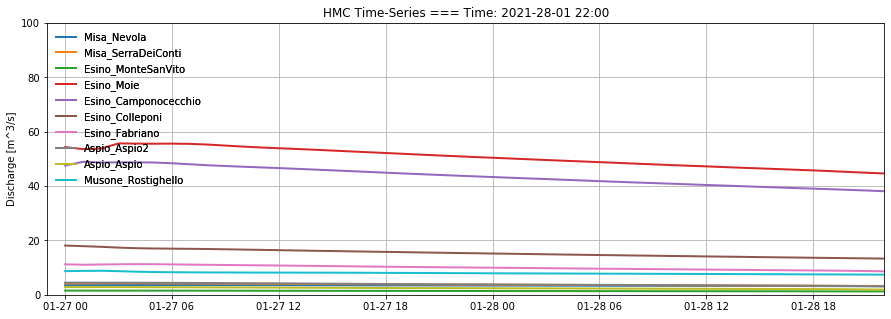

In [88]:
# Procedure to keep alive iterations for checking new datasets in the target folder(s)

# Group key
key_group = 4
while True:
    try:
        # Get file hydrograph time-series datasets
        file_dframe_live = read_file_ascii_hydrograph(file_name_hydrograph, file_columns=section_list_all)
        
        # Get file hydrograph time-series information
        time_stamp_min, time_stamp_max = get_info_realtime(file_dframe_live)
        # Adjust file hydrograph time-series (related to the run period)
        file_dframe_adjust = adjust_ts_realtime(file_dframe_live, time_series_collections['deterministic'].index)
        
        # Select section group 
        section_list_select = section_list_all[int(section_group_dict[key_group][1]):int(section_group_dict[key_group][2])]
        # Select dataframe group
        file_dframe_select = file_dframe_adjust[section_list_select]

        # Define time-series plot filename
        group_str = section_group_dict[key_group][0]
        file_path_images_step = file_name_images.format(time_name=time_stamp_max.strftime('%Y%d%m_%H00'), group_name=group_str)
        folder_name_step, file_name_step = os.path.split(file_path_images_step)
        make_folder(folder_name_step)

        # Call the function to plot the time-series
        plot_ts_realtime(file_path_images_step, time_stamp_max, file_dframe_select)
        
        # Group key
        key_group = 1
        
        # Select section group 
        section_list_select = section_list_all[int(section_group_dict[key_group][1]):int(section_group_dict[key_group][2])]
        # Select dataframe group
        file_dframe_select = file_dframe_adjust[section_list_select]

        # Define time-series plot filename
        group_str = section_group_dict[key_group][0]
        file_path_images_step = file_name_images.format(time_name=time_stamp_max.strftime('%Y%d%m_%H00'), group_name=group_str)
        folder_name_step, file_name_step = os.path.split(file_path_images_step)
        make_folder(folder_name_step)

        # Call the function to plot the time-series
        plot_ts_realtime(file_path_images_step, time_stamp_max, file_dframe_select)
        
        time.sleep(10)
        
    except KeyboardInterrupt:
        break